In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import glob
from scipy.signal import fftconvolve, convolve
from scipy.special import erfc
from scipy.optimize import curve_fit
from lmfit.models import Model, LorentzianModel, GaussianModel

In [4]:
path = r'data/4-15/unlocked' 
path2 = r'data/4-15/locked' 
file_pattern = 'data_*.csv'

all_files_unlocked = glob.glob(path + '/' + file_pattern)
all_files_locked = glob.glob(path2 + '/' + file_pattern)

all_df_unlocked = []

for f in all_files_unlocked:
    df = pd.read_csv(f, skiprows=5)
    all_df_unlocked.append(df)

all_df_locked = []

for f in all_files_locked:
    df = pd.read_csv(f, skiprows=5)
    all_df_locked.append(df)

(-0.0065, -0.004)

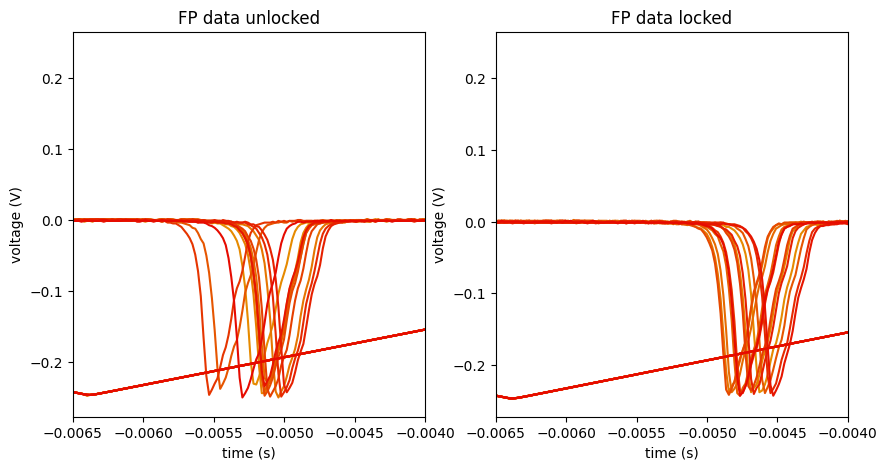

In [5]:
from matplotlib.colors import hsv_to_rgb

def generate_color(factor):
    hue = 0.1 - factor * 0.1  # Linearly interpolate from 0.1 to 0.0
    saturation = 1  # Full saturation for vivid colors
    value = 0.9  # Lower brightness for darker colors
    return hsv_to_rgb((hue, saturation, value))

fig, ax = plt.subplots(1,2, figsize=(10, 5))

for i, df in enumerate(all_df_unlocked):
    factor = i / len(all_df_unlocked)  # Normalize factor between 0 and 1
    color = generate_color(factor)
    ax[0].plot(df['time'], df['ch1'], label='ch1', color=color)
    ax[0].plot(df['time'], df['ch2']/20, label='ch2', color=color)
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('voltage (V)')
ax[0].set_title('FP data unlocked')
ax[0].set_xlim(-0.0065, -0.004)
factor = 0
for i, df in enumerate(all_df_locked[:13]):
    factor = i / len(all_df_locked[:13])  # Normalize factor between 0 and 1
    color = generate_color(factor)
    ax[1].plot(df['time'], df['ch1'], label='ch1', color=color)
    ax[1].plot(df['time'], df['ch2']/20, label='ch2', color=color)
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('voltage (V)')
ax[1].set_title('FP data locked')
ax[1].set_xlim(-0.0065, -0.004)

    

Text(0, 0.5, 'voltage (V)')

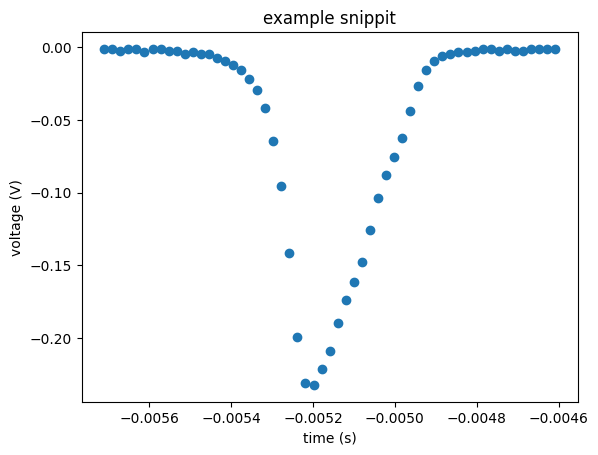

In [6]:
snippit = all_df_unlocked[0].to_numpy()[np.where(all_df_unlocked[0]['time'] < -0.0057)[0][-1]:
                                        np.where(all_df_unlocked[0]['time'] > -0.0046)[0][0],:]
plt.scatter(snippit[:,2], snippit[:,0])
plt.title('example snippit')
plt.xlabel('time (s)')
plt.ylabel('voltage (V)')

OF ALL THE MULTIPLE PEAK OPTIONS THIS ONE BELOW SEEMS THE BEST. NO BUGS INVOLVING CONVOLUTIONS. THAT BEING SAID, FITTING STILL PRETTY UNSTABLE.

Text(0, 0.5, 'ch1 (V)')

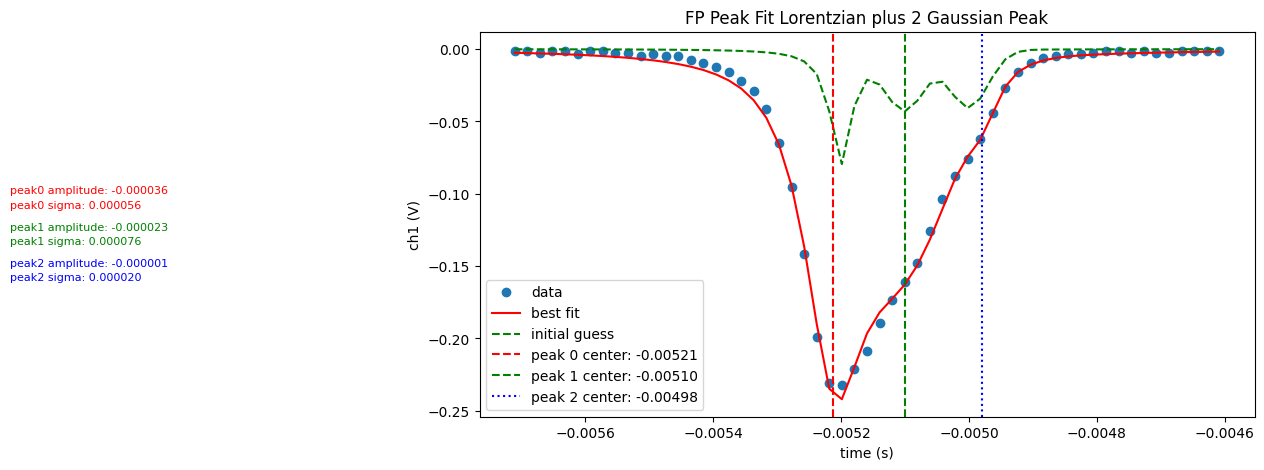

In [7]:
model = LorentzianModel(prefix='peak0_')
for i in range(1,3):  # Fit 3 sub-peaks
    model += GaussianModel(prefix=f'peak{i}_')
params = model.make_params(peak0_amplitude=-0.000005, peak0_center=-0.0052, peak0_sigma=0.00002, 
                           peak1_amplitude=-0.000003, peak1_center=-0.0051, peak1_sigma=0.00003,
                           peak2_amplitude=-0.000003, peak2_center=-0.0050, peak2_sigma=0.00003)



params['peak0_center'].min = -0.0053
params['peak0_center'].max = -0.00518
params['peak1_center'].min = -0.0052
params['peak1_center'].max = -0.0050
params['peak2_center'].min = -0.00503
params['peak2_center'].max = -0.00495

params['peak0_amplitude'].max = 0
params['peak1_amplitude'].max = 0
params['peak2_amplitude'].max = 0

params['peak0_sigma'].min = 0
params['peak1_sigma'].min = 0
params['peak2_sigma'].min = 0
params['peak0_sigma'].max = 0.001
params['peak1_sigma'].max = 0.00045
params['peak2_sigma'].max = 0.00045


result = model.fit(snippit[:,0], params, x=snippit[:,2])
#print(result.fit_report())
plt.figure(figsize=(10, 5))
plt.plot(snippit[:,2], snippit[:,0], 'o', label='data')
plt.plot(snippit[:,2], result.best_fit, 'r-', label='best fit')
plt.plot(snippit[:,2], result.init_fit, 'g--', label='initial guess')
plt.axvline(x=result.params['peak0_center'].value, color='r', linestyle='--', label=f'peak 0 center: {result.params['peak0_center'].value:.5f}')
plt.axvline(x=result.params['peak1_center'].value, color='g', linestyle='--', label=f'peak 1 center: {result.params['peak1_center'].value:.5f}')
plt.axvline(x=result.params['peak2_center'].value, color='b', linestyle=':', label=f'peak 2 center: {result.params['peak2_center'].value:.5f}')
plt.legend()
plt.text(-0.0065, -0.1, f'peak0 amplitude: {result.params['peak0_amplitude'].value:.6f}', fontsize=8, color='red')
plt.text(-0.0065, -0.11, f'peak0 sigma: {result.params['peak0_sigma'].value:.6f}', fontsize=8, color='red')
plt.text(-0.0065, -0.125, f'peak1 amplitude: {result.params['peak1_amplitude'].value:.6f}', fontsize=8, color='green')
plt.text(-0.0065, -0.135, f'peak1 sigma: {result.params['peak1_sigma'].value:.6f}', fontsize=8, color='green')
plt.text(-0.0065, -0.15, f'peak2 amplitude: {result.params['peak2_amplitude'].value:.6f}', fontsize=8, color='blue')
plt.text(-0.0065, -0.16, f'peak2 sigma: {result.params['peak2_sigma'].value:.6f}', fontsize=8, color='blue')
plt.title('FP Peak Fit Lorentzian plus 2 Gaussian Peak')
plt.xlabel('time (s)')
plt.ylabel('ch1 (V)')

Looks like we need an expoonential tail also applied?
TRIPLE GAUSSIAN WITH EXPONENTIAL BLUR: SEEMS LIKE CONV DOESN'T DO THAT MUCH BESIDES BREAK THE CODE FOR RANDOM VALUES OF EXP_DECAY. PROBABLY DONT WANT TO GO WITH THIS ONE

In [8]:
# Define a Lorentzian function
def lorentzian(x, amplitude, center, sigma):
    return (amplitude / np.pi) * (sigma / ((x - center)**2 + sigma**2))

def gaussian(x, amplitude, center, sigma):
    return amplitude * np.exp(-0.5 * ((x - center) / sigma)**2)

# Define an exponential tail function with bounds for use as a kernel
def exponential_tail(x, amp, decay):
    return amp * (np.exp(-x / decay))

def convolved_model_gaussian(x, amp0, center0, sigma0, 
                    amp1, center1, sigma1, 
                    amp2, center2, sigma2, 
                    exp_amp, exp_decay):
    

    # Calculate padding needed
    dx = x[1] - x[0]
    pad_width = int(np.round(15 * exp_decay / dx))  # 15× decay constant for safety

    # Create extended x-range
    x_ext = np.arange(x[0] - pad_width*dx, x[-1] + pad_width*dx, dx)

    # Gaussian peaks on the padded range
    gauss0 = gaussian(x_ext, amp0, center0, sigma0)
    gauss1 = gaussian(x_ext, amp1, center1, sigma1)
    gauss2 = gaussian(x_ext, amp2, center2, sigma2)
    
    sum_gauss_ext = gauss0 + gauss1 + gauss2

    # Create exponential kernel
    kernel_length = 10 * exp_decay  # 10× decay constant
    kernel_x = np.arange(0, kernel_length, dx)
    exp_kernel = exponential_tail(kernel_x, exp_amp, exp_decay) 
    exp_kernel /= np.sum(exp_kernel)

    # Perform convolution on extended range
    conv_ext = fftconvolve(sum_gauss_ext, exp_kernel, mode='same')
    
    # Extract only the original range portion
    start_idx = pad_width
    end_idx = start_idx + len(x)

    # print(f'15*exp_decay/dx: {15*exp_decay/dx}')
    # print(f'pad width = start_idx: {pad_width}')
    # print(f'dx {dx}')
    # print(f'end_idx: {end_idx}')
    # print(x.shape, x_ext[start_idx:end_idx].shape, conv_ext[start_idx:end_idx].shape)
    # print(np.allclose(x, x_ext[start_idx:end_idx], atol=1e-12))
    # print(x)
    # print(x_ext[start_idx:end_idx])

    return conv_ext[start_idx:end_idx]


In [9]:
convolved_model_gaussian(snippit[:,2], amp0=-0.1, center0=-0.0052, sigma0=0.000002,
    amp1=-0.1, center1=-0.0051, sigma1=0.000002,
    amp2=-0.1, center2=-0.0050, sigma2=0.000002,
    exp_amp=1, exp_decay=0.00049)

array([-2.25989621e-04, -2.17092995e-04, -2.08546605e-04, -2.00336665e-04,
       -1.92449929e-04, -1.84873674e-04, -1.77595676e-04, -1.70604194e-04,
       -1.63887948e-04, -1.57436104e-04, -1.51238252e-04, -1.45284393e-04,
       -1.39564923e-04, -1.34070613e-04, -1.28792600e-04, -1.23722369e-04,
       -1.18851739e-04, -1.14172854e-04, -1.09678164e-04, -1.05360419e-04,
       -1.01212652e-04, -9.72281717e-05, -9.34005503e-05, -8.97236124e-05,
       -8.61914260e-05, -8.27982926e-05, -7.95387382e-05, -7.64075039e-05,
       -7.33995383e-05, -7.05099884e-05, -6.77341927e-05, -6.50676728e-05,
       -6.25061270e-05, -6.00454226e-05, -5.76815897e-05, -5.54108148e-05,
       -5.32294344e-05, -5.11339294e-05, -4.91209189e-05, -4.71871555e-05,
       -4.53295193e-05, -4.35450135e-05, -4.18307590e-05, -4.01839903e-05,
       -3.86020506e-05, -3.70823878e-05, -3.56225502e-05, -3.42201826e-05,
       -3.28730226e-05, -3.15788968e-05, -3.03357173e-05, -2.91414787e-05,
       -2.79942541e-05, -

snippit[:, 0] shape: (57,)
snippit[:, 2] shape: (57,)


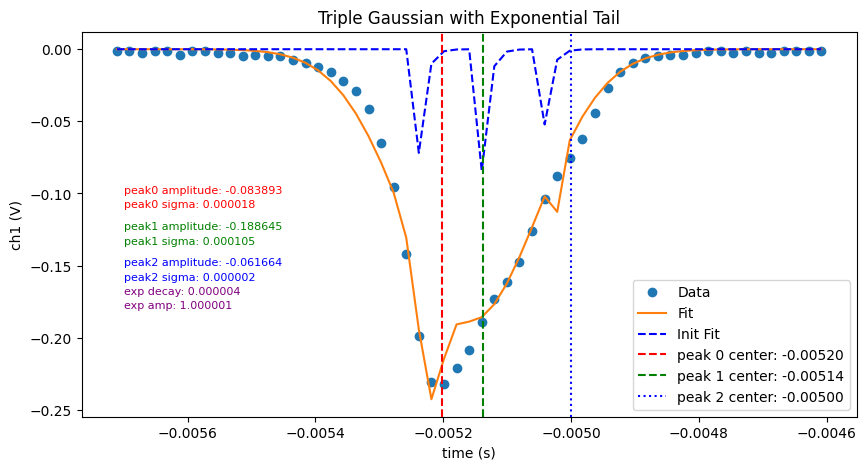

[[Model]]
    Model(convolved_model_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 106
    # data points      = 57
    # variables        = 11
    chi-square         = 0.00413040
    reduced chi-square = 8.9791e-05
    Akaike info crit   = -521.348680
    Bayesian info crit = -498.875116
    R-squared          = 0.98608179
[[Variables]]
    amp0:      -0.08389340 +/- 0.01523567 (18.16%) (init = -0.1)
    center0:   -0.00520135 +/- 4.9140e-06 (0.09%) (init = -0.0052)
    sigma0:     1.8095e-05 +/- 3.7823e-06 (20.90%) (init = 2e-06)
    amp1:      -0.18864533 +/- 0.00716749 (3.80%) (init = -0.1)
    center1:   -0.00513840 +/- 7.2410e-06 (0.14%) (init = -0.0051)
    sigma1:     1.0519e-04 +/- 2.7903e-06 (2.65%) (init = 2e-06)
    amp2:      -0.06166364 +/- 1.3734e+08 (222719077769.33%) (init = -0.1)
    center2:   -0.00499968 +/- 79505.5794 (1590214857.29%) (init = -0.005)
    sigma2:     2.0039e-06 +/- 68428.9862 (3414716030715.97%) (init = 2e-06)


In [10]:
conv_model = Model(convolved_model_gaussian, independent_vars=['x'])

params2 = conv_model.make_params(
    amp0=-0.1, center0=-0.0052, sigma0=0.000002,
    amp1=-0.1, center1=-0.0051, sigma1=0.000002,
    amp2=-0.1, center2=-0.0050, sigma2=0.000002,
    exp_amp=1, exp_decay=0.0005
)

params2['amp0'].max = 0
params2['amp1'].max = 0
params2['amp2'].max = 0

params2['center0'].min = -0.006
params2['center0'].max = -0.003
params2['center1'].min = -0.006
params2['center1'].max = -0.003
params2['center2'].min = -0.006
params2['center2'].max = -0.003

params2['sigma0'].min = 0
params2['sigma1'].min = 0
params2['sigma2'].min = 0
params2['sigma0'].max = 0.00055
params2['sigma1'].max = 0.00045
params2['sigma2'].max = 0.00045

params2['exp_decay'].min = 0.000001  # Constrain decay to avoid unphysical values
params2['exp_decay'].max = 0.00001  # Constrain decay to avoid unphysical values

# Fit the model to the data
print(f"snippit[:, 0] shape: {snippit[:, 0].shape}")
print(f"snippit[:, 2] shape: {snippit[:, 2].shape}")
result2 = conv_model.fit(snippit[:, 0], params2, x=snippit[:, 2])

# Plot the fit
plt.figure(figsize=(10, 5))
plt.plot(snippit[:, 2], snippit[:, 0], 'o', label='Data')
plt.plot(snippit[:, 2], result2.best_fit, '-', label='Fit')
plt.plot(snippit[:, 2], result2.init_fit, 'b--', label='Init Fit')
plt.axvline(x=result2.params['center0'].value, color='r', linestyle='--', label=f'peak 0 center: {result2.params['center0'].value:.5f}')
plt.axvline(x=result2.params['center1'].value, color='g', linestyle='--', label=f'peak 1 center: {result2.params['center1'].value:.5f}')
plt.axvline(x=result2.params['center2'].value, color='b', linestyle=':', label=f'peak 2 center: {result2.params['center2'].value:.5f}')
plt.text(-0.0057, -0.1, f'peak0 amplitude: {result2.params['amp0'].value:.6f}', fontsize=8, color='red')
plt.text(-0.0057, -0.11, f'peak0 sigma: {result2.params['sigma0'].value:.6f}', fontsize=8, color='red')
plt.text(-0.0057, -0.125, f'peak1 amplitude: {result2.params['amp1'].value:.6f}', fontsize=8, color='green')
plt.text(-0.0057, -0.135, f'peak1 sigma: {result2.params['sigma1'].value:.6f}', fontsize=8, color='green')
plt.text(-0.0057, -0.15, f'peak2 amplitude: {result2.params['amp2'].value:.6f}', fontsize=8, color='blue')
plt.text(-0.0057, -0.16, f'peak2 sigma: {result2.params['sigma2'].value:.6f}', fontsize=8, color='blue')
plt.text(-0.0057, -0.17, f'exp decay: {result2.params['exp_decay'].value:.6f}', fontsize=8, color='purple')
plt.text(-0.0057, -0.18, f'exp amp: {result2.params['exp_amp'].value:.6f}', fontsize=8, color='purple')
plt.legend()
plt.ylabel('ch1 (V)')
plt.xlabel('time (s)')
plt.title('Triple Gaussian with Exponential Tail')
plt.show()

# Print the fit report
print(result2.fit_report())

HALF GAUSS/LORENTZIAN: STABLE BUT GOOFY

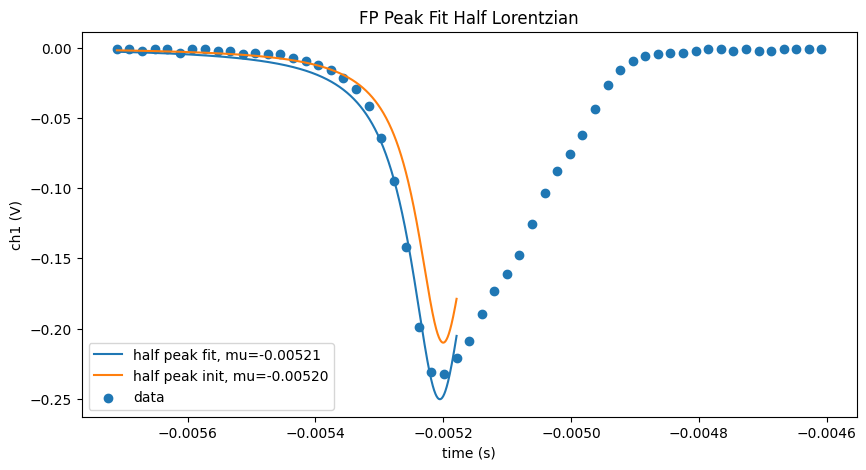

In [11]:
def lorentzian2(x, amplitude, center, fwhm):
    """Normalized Lorentzian with independent parameters"""
    gamma = fwhm / 2.0
    return amplitude * (gamma**2) / ((x - center)**2 + gamma**2)

def fit_half_peak(x, y, amp_guess, center_guess, sigma_guess, buffer=0, peak='Gaussian', plot=True):
    min_y_i = np.argmin(y)
    y_cut = y[:min_y_i+buffer]
    x_cut = x[:min_y_i+buffer]
    time_range_hg = np.linspace(x_cut[0], x_cut[-1], 1000)
    if peak == 'Gaussian':
        popt_hg, pcov_hg = curve_fit(gaussian, x_cut, y_cut, p0=[amp_guess, center_guess, sigma_guess])
        init_hg = gaussian(time_range_hg, amp_guess, center_guess, sigma_guess)
        fit_hg = gaussian(time_range_hg, *popt_hg)
    elif peak == 'Lorentzian':
        popt_hg, pcov_hg = curve_fit(lorentzian2, x_cut, y_cut, p0=[amp_guess, center_guess, sigma_guess])
        init_hg = lorentzian2(time_range_hg, amp_guess, center_guess, sigma_guess)
        fit_hg = lorentzian2(time_range_hg, *popt_hg)
    else:
        raise ValueError("Invalid peak type. Choose 'Gaussian' or 'Lorentzian'.")
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(time_range_hg, fit_hg, label=f'half peak fit, mu={popt_hg[1]:.5f}')
        plt.plot(time_range_hg, init_hg, label=f'half peak init, mu={center_guess:.5f}')
        plt.scatter(snippit[:,2], snippit[:,0], label='data')
        plt.ylabel('ch1 (V)')
        plt.xlabel('time (s)')
        plt.title(f'FP Peak Fit Half {peak}')
        plt.legend()

#fit_half_peak(snippit[:,2], snippit[:,0], -0.25, -0.006, 0.0001, buffer=3, peak='Gaussian')
fit_half_peak(snippit[:,2], snippit[:,0], -0.21, -0.0052, 0.0001, buffer=2, peak='Lorentzian')

CAP FIT: STABLE BUT REALLY GOOFY.
DATA NOT DENSE ENOUGH NEAR PEAKS FOR THIS TO BE OK LOL

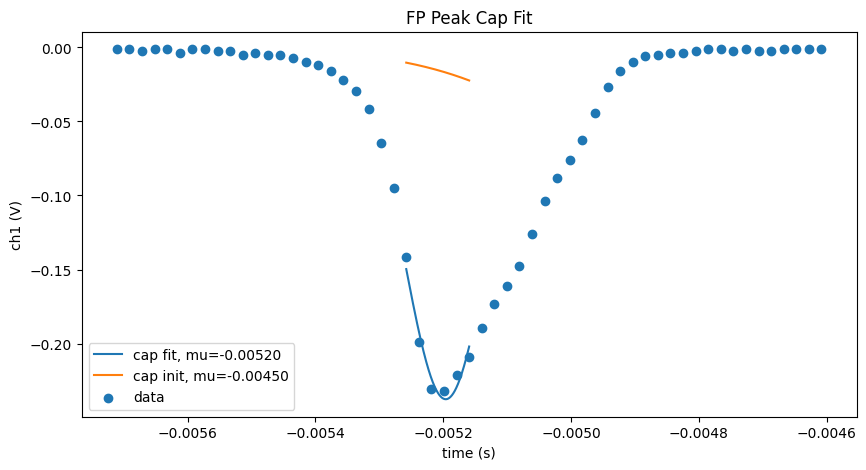

In [12]:
def fit_cap(x, y, amp_guess, center_guess, sigma_guess, buffer=0, plot=True):
    min_y_i = np.argmin(y)
    y_cut = y[min_y_i-buffer:min_y_i+buffer]
    x_cut = x[min_y_i-buffer:min_y_i+buffer]
    time_range_hg = np.linspace(x_cut[0], x_cut[-1], 1000)
    popt_hg, pcov_hg = curve_fit(gaussian, x_cut, y_cut, p0=[amp_guess, center_guess, sigma_guess])
    init_hg = gaussian(time_range_hg, amp_guess, center_guess, sigma_guess)
    fit_hg = gaussian(time_range_hg, *popt_hg)
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(time_range_hg, fit_hg, label=f'cap fit, mu={popt_hg[1]:.5f}')
        plt.plot(time_range_hg, init_hg, label=f'cap init, mu={center_guess:.5f}')
        plt.scatter(snippit[:,2], snippit[:,0], label='data')
        plt.ylabel('ch1 (V)')
        plt.xlabel('time (s)')
        plt.title(f'FP Peak Cap Fit')
        plt.legend()

fit_cap(snippit[:,2], snippit[:,0], -0.25, -0.0045, 0.0003, buffer=3, plot=True)

EXPONENTIAL GAUSSIAN: STABLE-ish

In [13]:
def simple_expgauss(x, amp, center, sigma, exp_decay):
    lambd = 1 / exp_decay
    arg = (center + lambd * sigma**2 - x) / (sigma * np.sqrt(2))
    exponent = 0.5 * lambd * (2 * center + lambd * sigma**2 - 2 * x)
    
    return 0.5 * amp * lambd * np.exp(exponent) * erfc(arg)



[-5.56543633e-05 -5.23999036e-03  6.40257022e-05  1.00034411e-04]


/tmp/ipykernel_415806/2253653366.py:6: RuntimeWarning: overflow encountered in exp
  return 0.5 * amp * lambd * np.exp(exponent) * erfc(arg)
/tmp/ipykernel_415806/2253653366.py:6: RuntimeWarning: invalid value encountered in multiply
  return 0.5 * amp * lambd * np.exp(exponent) * erfc(arg)


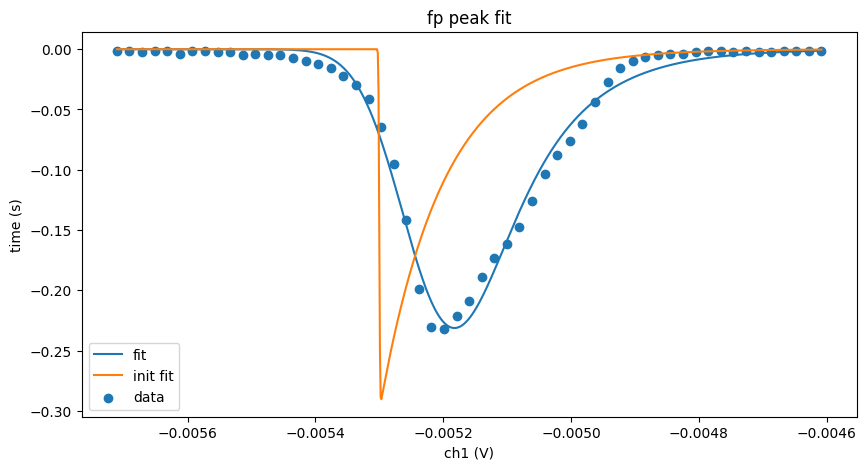

In [14]:
def fit_expgauss(x, y, amp_guess, center_guess, sigma_guess, exp_decay_guess, plot=True):
    popt, pcov = curve_fit(simple_expgauss, x, y, p0=[amp_guess, center_guess, sigma_guess, exp_decay_guess])
    time_range = np.linspace(x[0], x[-1], 1000)
    fit = simple_expgauss(time_range, *popt)
    init_fit = simple_expgauss(time_range, amp_guess, center_guess, sigma_guess, exp_decay_guess)
    plt.figure(figsize=(10,5))
    plt.plot(time_range, fit, label='fit')
    plt.plot(time_range, init_fit, label='init fit')
    plt.scatter(x,y, label='data')
    plt.xlabel('ch1 (V)')
    plt.ylabel('time (s)')
    plt.title('fp peak fit')
    plt.legend()
    print(popt)

fit_expgauss(snippit[:,2], snippit[:,0], -0.00003, -0.0053, 0.000001, 0.0001)

EXPONENTIAL LORENTZIAN: UNSTABLE

[[Model]]
    Model(convolved_model_lorentz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 210
    # data points      = 57
    # variables        = 4
    chi-square         = 0.00684804
    reduced chi-square = 1.2921e-04
    Akaike info crit   = -506.530153
    Bayesian info crit = -498.357948
    R-squared          = 0.97692416
[[Variables]]
    amp0:      -6.3185e-05 +/- 1.5240e-06 (2.41%) (init = -6e-05)
    center0:   -0.00462928 +/- 2.7918e-06 (0.06%) (init = -0.0047)
    sigma0:     3.5262e-05 +/- 3.6874e-06 (10.46%) (init = 2e-05)
    exp_decay:  1.2202e-04 +/- 7.9532e-06 (6.52%) (init = 0.000125)
[[Correlations]] (unreported correlations are < 0.100)
    C(center0, exp_decay) = -0.7092
    C(sigma0, exp_decay)  = -0.6804
    C(center0, sigma0)    = +0.4834
    C(amp0, sigma0)       = -0.3911
    C(amp0, exp_decay)    = -0.1553
    C(amp0, center0)      = +0.1096


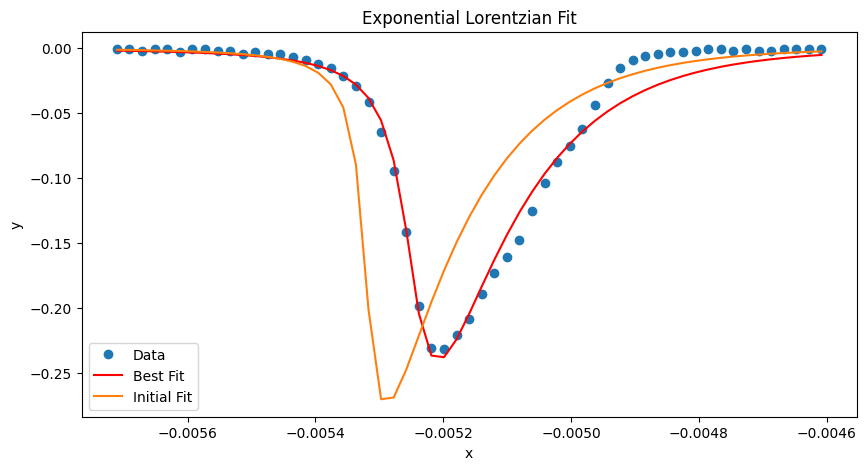

In [15]:
# Define the convolved model (Lorentzian + Exponential Tail)
def convolved_model_lorentz(x, amp0, center0, sigma0, exp_decay):
    # Calculate padding needed
    dx = x[1] - x[0]
    pad_width = int(np.round(15 * exp_decay / dx))  # 15× decay constant for safety
    
    # Create extended x-range
    x_ext = np.arange(x[0] - pad_width*dx, x[-1] + pad_width*dx, dx)
    
    # Create Lorentzian on extended range
    lorentz_ext = lorentzian(x_ext, amp0, center0, sigma0)
    
    # Create exponential kernel
    kernel_x = np.arange(0, 10*exp_decay, dx)
    exp_kernel = exponential_tail(kernel_x, 1, exp_decay)
    exp_kernel /= np.sum(exp_kernel)
    
    # Perform convolution on extended range
    conv_ext = convolve(lorentz_ext, exp_kernel, mode='same')
    
    # Extract only the original range portion
    start_idx = pad_width
    end_idx = start_idx + len(x)
    return conv_ext[start_idx:end_idx]

def fit_explor(x, y, amp_guess, center_guess, sigma_guess, exp_decay_guess, plot=True):
    conv_lor_model = Model(convolved_model_lorentz, independent_vars=['x'])
    params_lor = conv_lor_model.make_params(
        amp0=amp_guess, center0=center_guess, sigma0=sigma_guess,
        exp_decay=exp_decay_guess
    )
    params_lor['amp0'].max = 0
    params_lor['center0'].min = -0.006
    params_lor['center0'].max = -0.003
    params_lor['sigma0'].min = 0
    params_lor['sigma0'].max = 0.001
    params_lor['exp_decay'].min = 0.0000001  # Constrain decay to avoid unphysical values
    params_lor['exp_decay'].max = 0.01  # Constrain decay to avoid unphysical values
    # Fit the model to the data
    result_lor = conv_lor_model.fit(y, params_lor, x=x)

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(x, y, 'o', label='Data')
        plt.plot(x, result_lor.best_fit, 'r-', label='Best Fit')
        plt.plot(x, result_lor.init_fit, '-', label='Initial Fit')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Exponential Lorentzian Fit')
        plt.legend()
        print(result_lor.fit_report())

fit_explor(snippit[:,2], snippit[:,0], -0.00006, -0.0047, 0.00002, 0.000125)

TRIANGLE WAVE FIT

In [18]:
def triangle(x, center, slope, bias):
    return bias - slope *np.abs(x - center)

In [39]:
nump = all_df_locked[0].to_numpy()
half_len = int(nump[:,0].shape[0]//2)
tri_x = nump[half_len:,2]
tri_y = nump[half_len:,1]


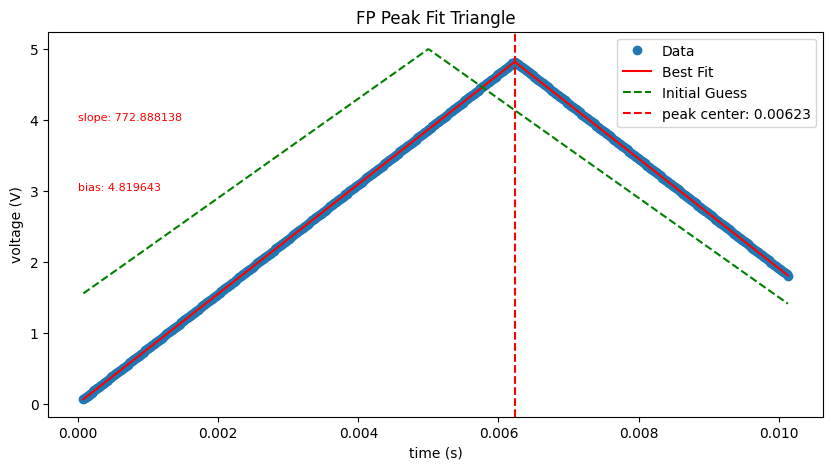

In [46]:
tri_model = Model(triangle, independent_vars=['x'])
params_tri = tri_model.make_params(center=0.005, slope=700, bias=5)
tri_result = tri_model.fit(tri_y, params_tri, x=tri_x)
plt.figure(figsize=(10, 5))
plt.plot(tri_x, tri_y, 'o', label='Data')
plt.plot(tri_x, tri_result.best_fit, 'r-', label='Best Fit')
plt.plot(tri_x, tri_result.init_fit, 'g--', label='Initial Guess')
plt.axvline(x=tri_result.params['center'].value, color='r', linestyle='--', label=f'peak center: {tri_result.params['center'].value:.5f}')
plt.text(0, 4, f'slope: {tri_result.params['slope'].value:.6f}', fontsize=8, color='red')
plt.text(0, 3, f'bias: {tri_result.params['bias'].value:.6f}', fontsize=8, color='red')
plt.xlabel('time (s)')
plt.ylabel('voltage (V)')
plt.title('FP Peak Fit Triangle')
plt.legend()
calibration_time = tri_result.params['center'].value